 - /kaggle/input/test-laplacian/nut.png
 - /kaggle/input/test-laplacian/nut.jpg
Ảnh: /kaggle/input/test-laplacian/nut.png
Số crack phát hiện: 12


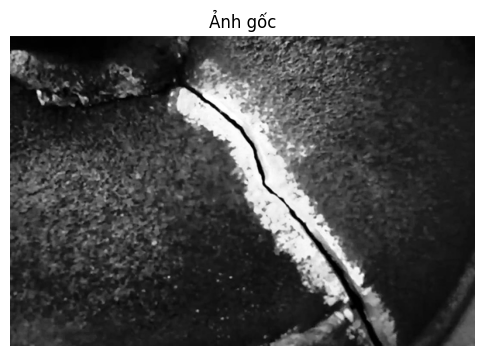

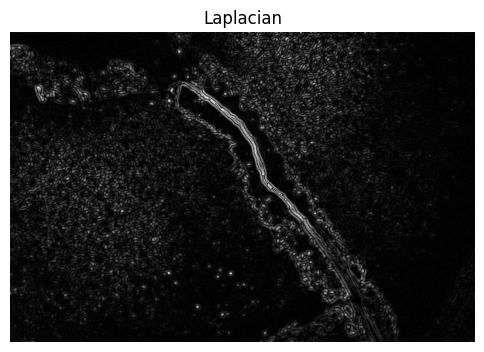

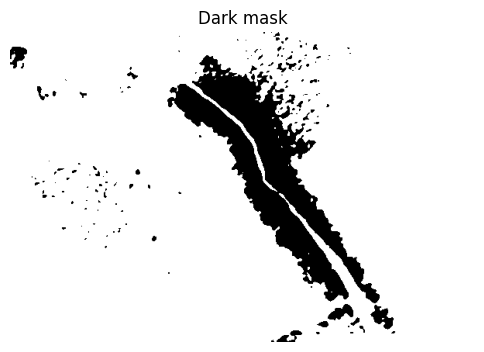

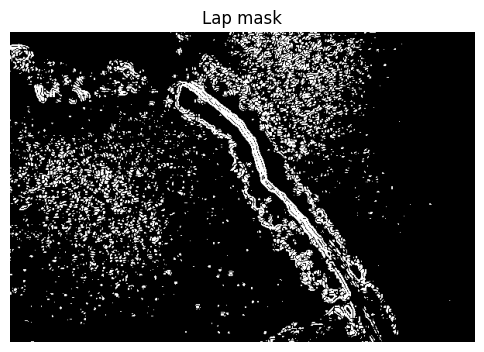

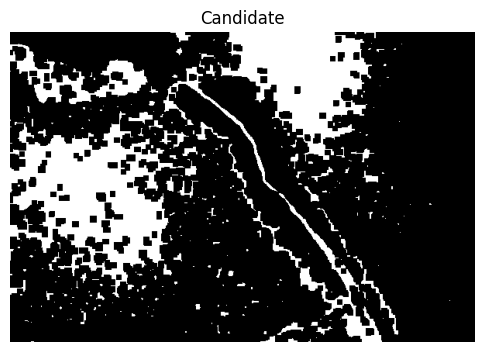

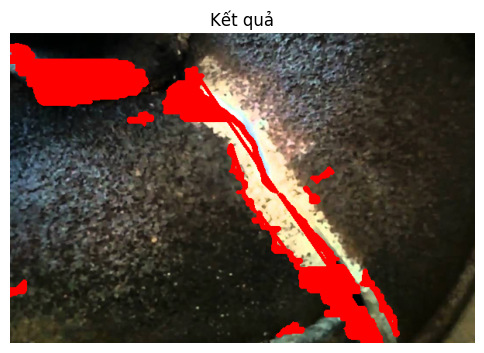

Ảnh: /kaggle/input/test-laplacian/nut.jpg
Số crack phát hiện: 12


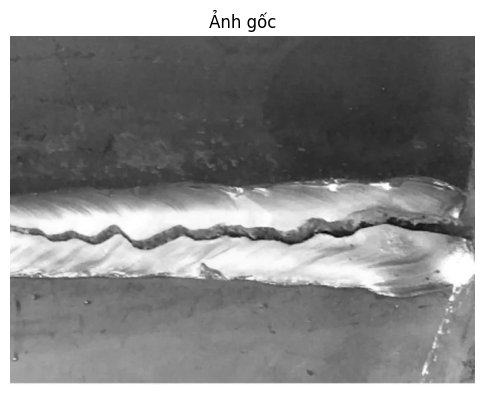

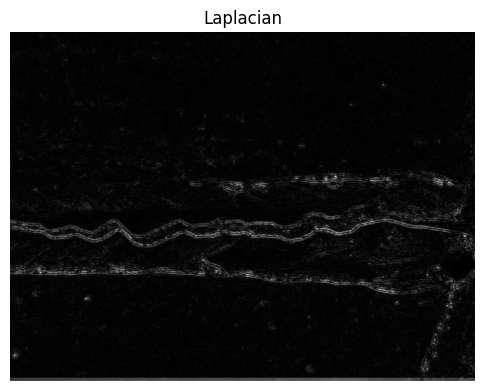

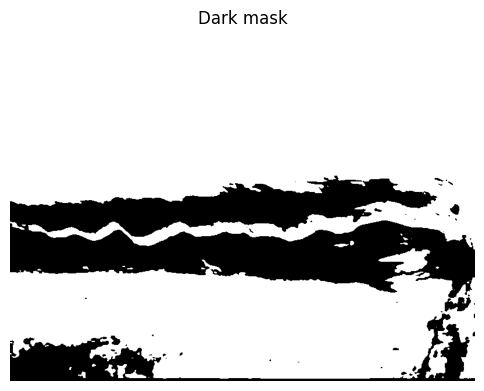

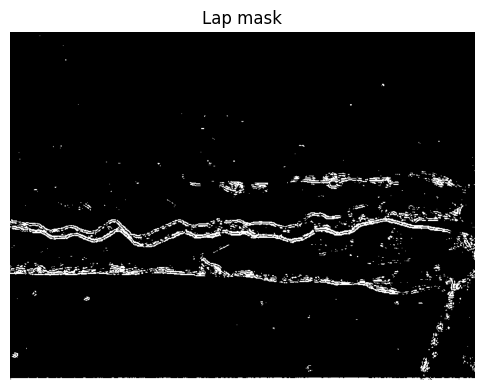

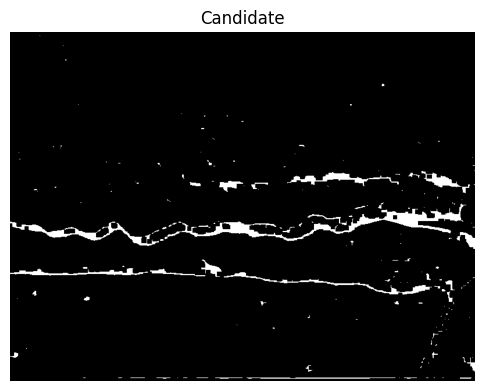

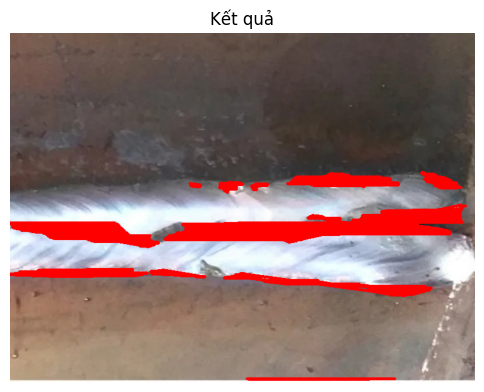

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def show(title, img):
    plt.figure(figsize=(6,6))
    if len(img.shape)==2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


def detect_crack_Lap_PCA(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray, (5,5), 1)

    lap = cv2.Laplacian(blur, cv2.CV_32F, ksize=3)
    lap_abs = np.uint8(np.absolute(lap))

    _, dark_mask = cv2.threshold(blur, 0, 255,
                                 cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    _, lap_mask = cv2.threshold(lap_abs, 0, 255,
                                cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    candidate = cv2.bitwise_and(dark_mask, lap_mask)

    kernel = np.ones((7,7), np.uint8)
    candidate = cv2.morphologyEx(candidate, cv2.MORPH_CLOSE, kernel, 2)

    num, labels = cv2.connectedComponents(candidate)

    result = img.copy()
    crack_count = 0

    for comp in range(1, num):
        ys, xs = np.where(labels == comp)
        pts = np.column_stack((xs, ys))

        if len(pts) < 80:
            continue

        pca = PCA(n_components=2)
        pca.fit(pts)

        eigvals = pca.explained_variance_

        if eigvals[0] / (eigvals[1] + 1e-5) < 6:
            continue

        crack_count += 1
        cv2.drawContours(result, [pts.reshape(-1,1,2)], -1, (0,0,255), 3)

    print("Ảnh:", image_path)
    print("Số crack phát hiện:", crack_count)

    show("Ảnh gốc", gray)
    show("Laplacian", lap_abs)
    show("Dark mask", dark_mask)
    show("Lap mask", lap_mask)
    show("Candidate", candidate)
    show("Kết quả", result)

image_dir = "/kaggle/input/test-laplacian"
valid_ext = [".jpg", ".jpeg", ".png", ".bmp"]

image_files = [
    os.path.join(image_dir, f)
    for f in os.listdir(image_dir)
    if os.path.splitext(f)[1].lower() in valid_ext
]

for f in image_files:
    print(" -", f)

for img_path in image_files:
    detect_crack_Lap_PCA(img_path)
